## Dimension Reduction
We aim to reduce the dimensionality of the input multivariate time series into a set of uncorrelated variables. After having done this we should be able to detect outliers by their deviation from the higest density region in the PCA space.

In [46]:
import datetime
import pandas as pd

multivariate_series = pd.read_csv('https://raw.githubusercontent.com/waico/SKAB/master/data/valve1/0.csv', delimiter=';')

multivariate_series

,datetime,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
0,2020-03-09 10:14:33,0.026588,0.040111,1.33020,0.054711,79.3366,26.0199,233.062,32.0000,0.0,0.0
1,2020-03-09 10:14:34,0.026170,0.040453,1.35399,0.382638,79.5158,26.0258,236.040,32.0000,0.0,0.0
2,2020-03-09 10:14:35,0.026199,0.039419,1.54006,0.710565,79.3756,26.0265,251.380,32.0000,0.0,0.0
3,2020-03-09 10:14:36,0.026027,0.039641,1.33458,0.382638,79.6097,26.0393,234.392,32.0000,0.0,0.0
4,2020-03-09 10:14:37,0.026290,0.040273,1.07851,-0.273216,79.6109,26.0420,225.342,32.0000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1142,2020-03-09 10:34:28,0.026789,0.040617,1.46938,0.054711,75.6738,25.8363,253.533,32.0000,0.0,0.0
1143,2020-03-09 10:34:29,0.027404,0.041474,1.18285,-0.273216,75.6865,25.8336,205.677,32.0000,0.0,0.0
1144,2020-03-09 10:34:30,0.026981,0.039410,1.19630,0.054711,75.6305,25.8358,208.907,32.0000,0.0,0.0
1145,2020-03-09 10:34:31,0.027245,0.040391,1.30745,0.054711,75.7601,25.8363,243.298,32.9986,0.0,0.0


## Multivariate time series plot

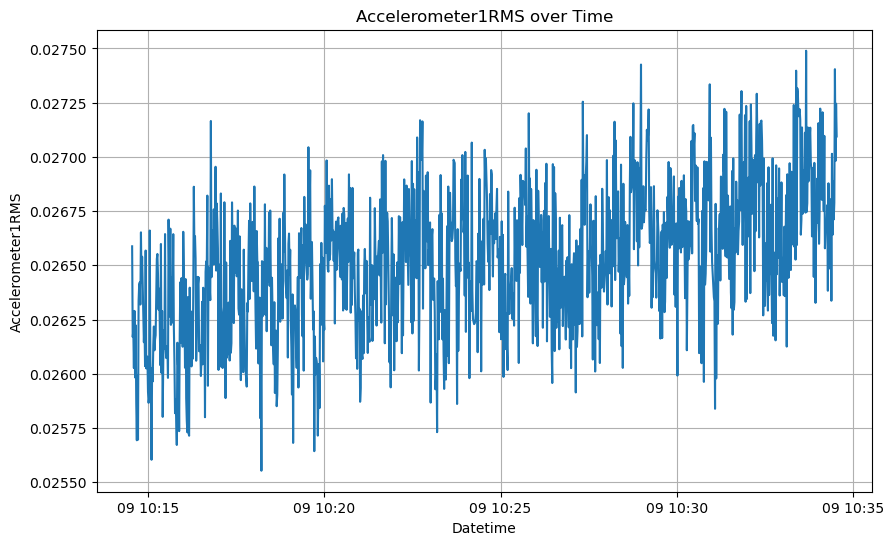

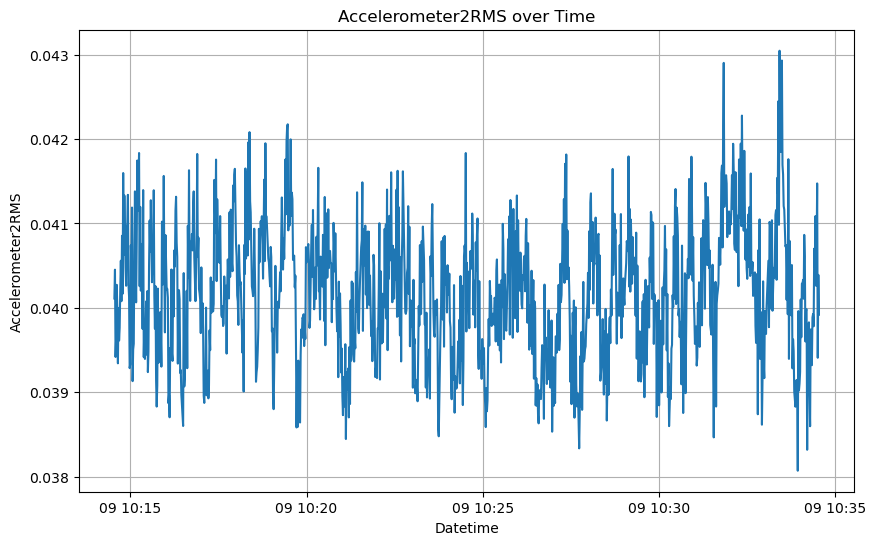

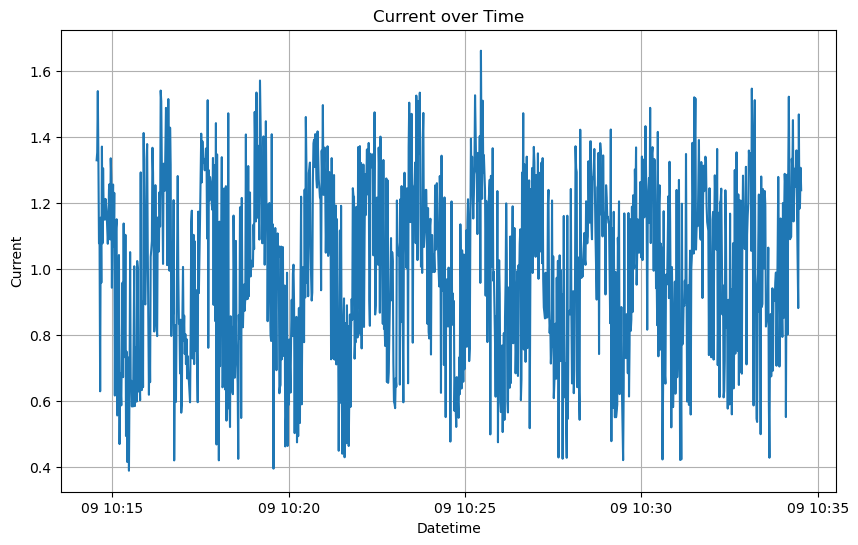

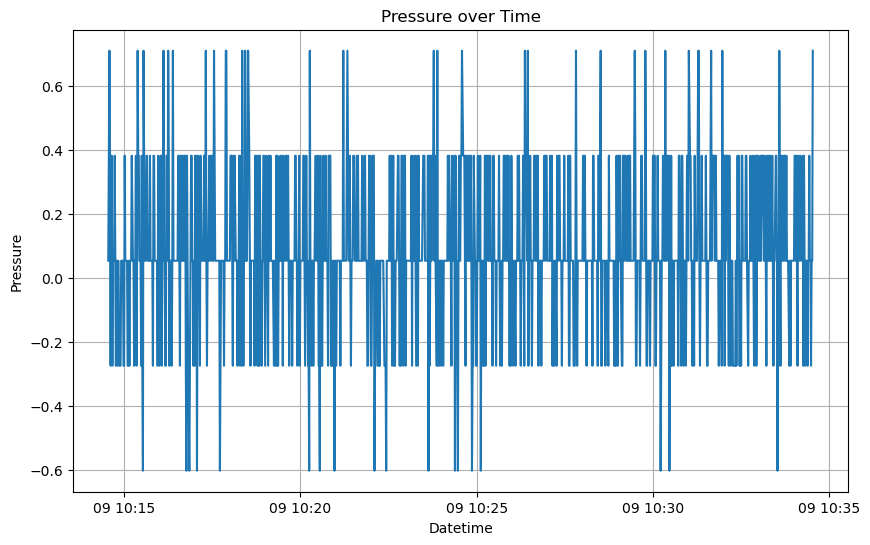

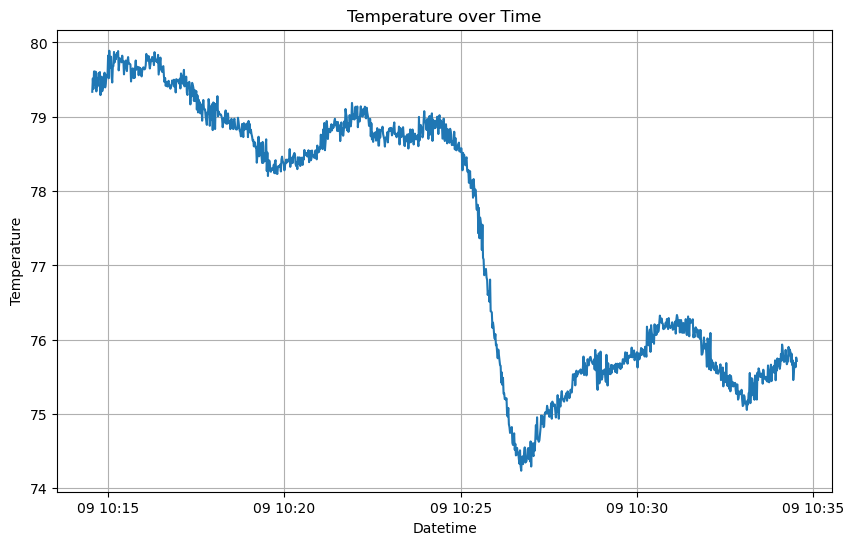

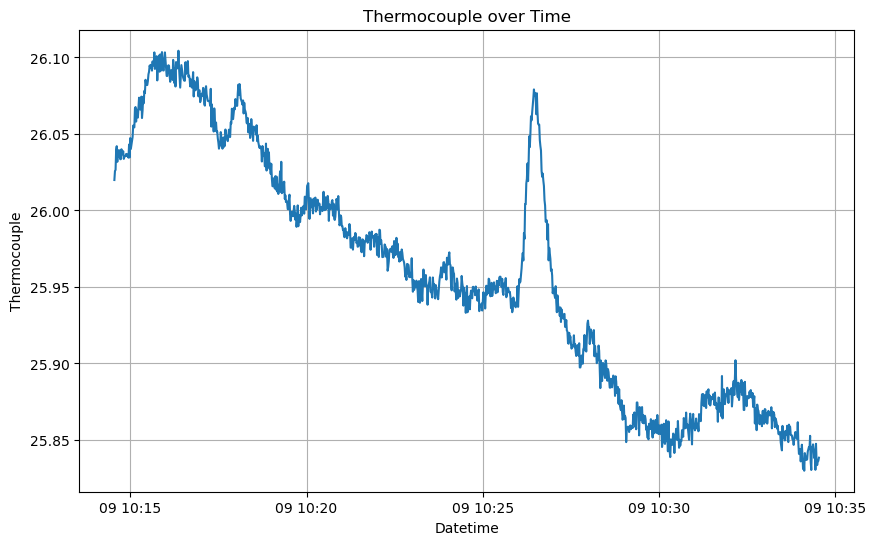

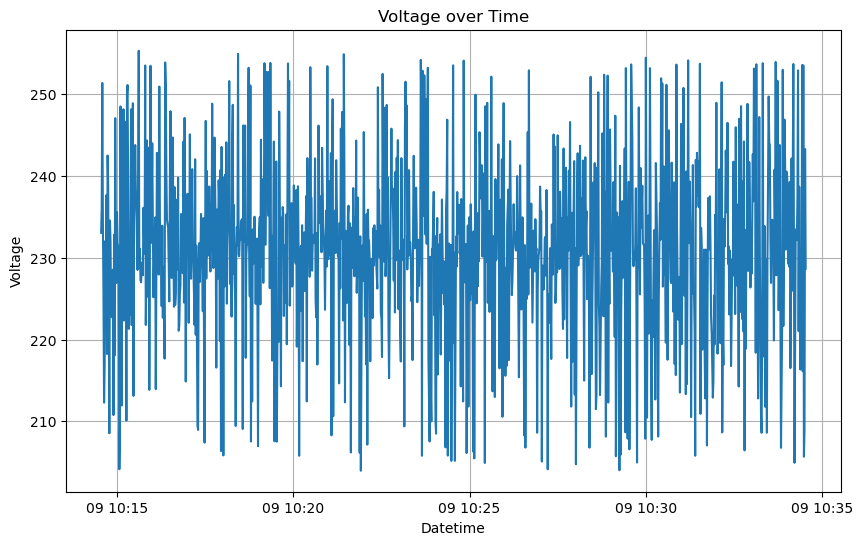

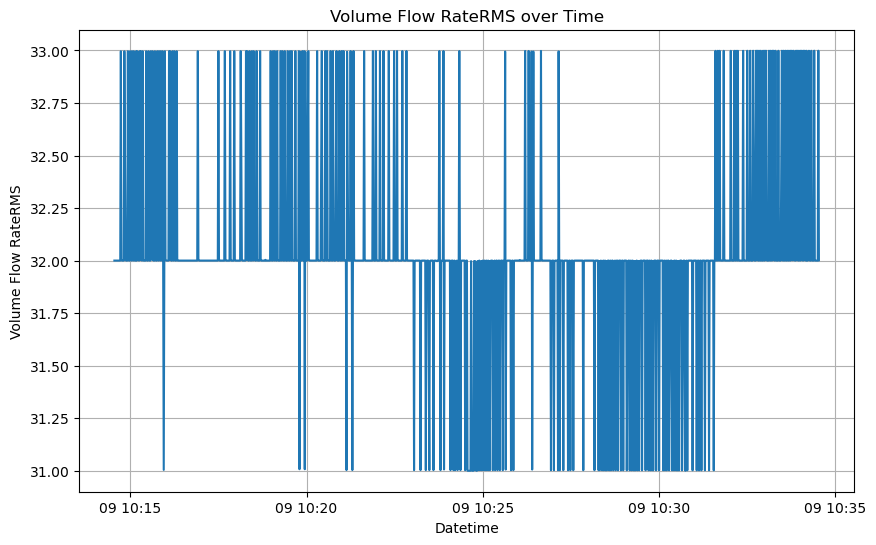

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

multivariate_series['datetime'] = pd.to_datetime(multivariate_series['datetime'])
multivariate_series.set_index('datetime', inplace=True)

columns_to_plot = multivariate_series.columns.difference(['anomaly', 'changepoint'])

for column in columns_to_plot:
    plt.figure(figsize=(10, 6))
    plt.plot(multivariate_series.index, multivariate_series[column])
    plt.title(f"{column} over Time")
    plt.xlabel("Datetime")
    plt.ylabel(column)
    plt.grid(True)
    plt.show()


## Detecting outliers

To reduce the dimensionality of the input, we first extract representative statistical features from each time series, namely the mean and first order autocorrelation.

We then apply PCA to the features (2 components used). From there we compute the cluster using k-means and than detect the outliers by computing the euclidean distance from the cluster centroids and the points.

Outliers detected:
Variable: Voltage - Index: 6
Variable: Accelerometer1RMS - Index: 0
Variable: Voltage - Index: 6


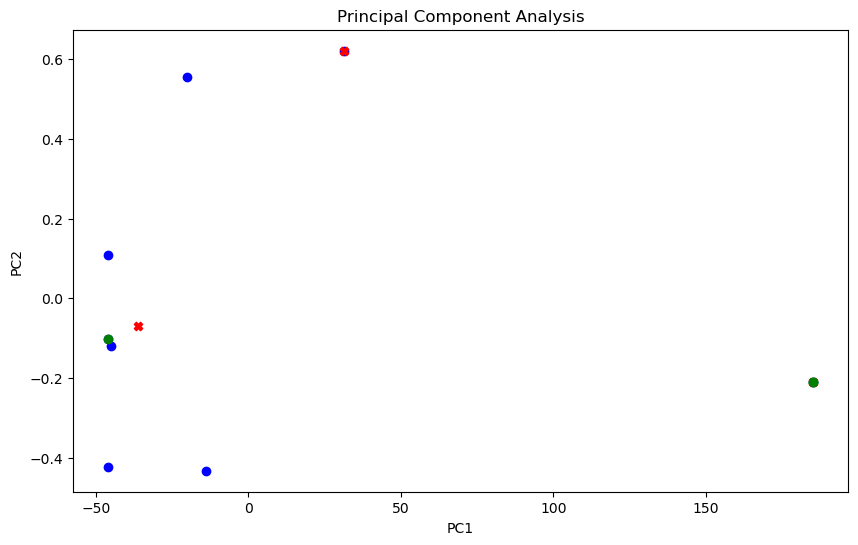

<Figure size 640x480 with 0 Axes>

In [48]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def extract_features(multivariate_series):
    features = []
    for series in multivariate_series.T:
        mean = np.mean(series)
        autocorrelation = np.corrcoef(series[:-1], series[1:])[0, 1]
        features.append([mean, autocorrelation])
    return np.array(features)

def detect_outliers_PCA(multivariate_series, n_components, n_clusters):
    features = extract_features_multivariate_time_series(multivariate_series)
    
    pca = PCA(n_components=n_components)
    pca.fit(features)
    reduced_features = pca.transform(features)
    
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(reduced_features)
    
    centroids = kmeans.cluster_centers_
    
    distances = cdist(reduced_features, centroids, 'euclidean')
    
    outliers = np.argmax(distances, axis=0)
    
    return reduced_features, centroids, outliers

n_components = 2
n_clusters = 3

multivariate_series = multivariate_series.drop(columns=['anomaly', 'changepoint'])
reduced_features, centroids, outliers = detect_outliers_PCA(multivariate_series.values, n_components, n_clusters)

variable_names = multivariate_series.columns.tolist()

print("Outliers detected:")
for outlier_index in outliers:
    print(f"Variable: {variable_names[outlier_index]} - Index: {outlier_index}")

plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c='blue')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X')
plt.scatter(reduced_features[outliers, 0], reduced_features[outliers, 1], c='green', marker='o')
plt.title("Principal Component Analysis")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

plt.savefig("pca.png")

## Outlier Variables
Via dimension reductionality we've detected the volatage and accelerometer1RMS variables as being outliers.